In [1]:
import pandas as pd
from mrmr import mrmr_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Lambda, Conv1D, Layer
from tensorflow.keras.models import Sequential

In [2]:
train_data = pd.read_csv("KDDTrain+.txt", header=None)
test_data = pd.read_csv("KDDTest+.txt", header=None)

In [3]:
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

train_data.columns = columns
test_data.columns = columns

train_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


### map normal to 0, all attacks to 1

In [4]:
# map normal to 0, all attacks to 1
train_attack = train_data.attack.map(lambda a: 0 if a == 'normal' else 1)
test_attack = test_data.attack.map(lambda a: 0 if a == 'normal' else 1)

train_data['attack_bit'] = train_attack
test_data['attack_bit'] = test_attack
test_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level,attack_bit
0,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,1
1,0,tcp,private,REJ,0,0,0,0,0,0,...,0.06,0.00,0.00,0.0,0.0,1.00,1.00,neptune,21,1
2,2,tcp,ftp_data,SF,12983,0,0,0,0,0,...,0.04,0.61,0.02,0.0,0.0,0.00,0.00,normal,21,0
3,0,icmp,eco_i,SF,20,0,0,0,0,0,...,0.00,1.00,0.28,0.0,0.0,0.00,0.00,saint,15,1
4,1,tcp,telnet,RSTO,0,15,0,0,0,0,...,0.17,0.03,0.02,0.0,0.0,0.83,0.71,mscan,11,1


In [5]:
train_data['attack_bit'].value_counts()

attack_bit
0    67343
1    58630
Name: count, dtype: int64

In [6]:
train_data_attack = train_data[train_data['attack_bit']==1]
train_data_attack.shape

(58630, 44)

In [7]:
# train_data_attack

In [8]:
train_data_non_attack = train_data[train_data['attack_bit']==0]
train_data_non_attack.shape

(67343, 44)

In [9]:
train_data_non_attack_downsampled = train_data_non_attack.sample(train_data_attack.shape[0])
train_data_non_attack_downsampled.shape

(58630, 44)

In [10]:
train_data_balanced = pd.concat([train_data_non_attack_downsampled, train_data_attack])
train_data_balanced.shape

(117260, 44)

In [11]:
columns_to_drop = ['attack_bit', 'level', 'attack']

In [12]:
x_train = train_data_balanced.drop(columns=columns_to_drop, axis=1)
y_train = train_data_balanced['attack_bit']

numeric_columns1 = x_train.select_dtypes(include=['number']).columns
categorical_columns1 = x_train.select_dtypes(exclude=['number']).columns
X_categorical1 = pd.get_dummies(x_train[categorical_columns1], drop_first=True)
train = pd.concat([x_train[numeric_columns1], X_categorical1], axis=1)
train = train.astype(int)

In [13]:
numeric_columns1

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')

In [14]:
categorical_columns1
# X_categorical1

Index(['protocol_type', 'service', 'flag'], dtype='object')

In [15]:
x_test = test_data.drop(columns=columns_to_drop, axis=1)
y_test = test_data['attack_bit']

numeric_columns2 = x_test.select_dtypes(include=['number']).columns
categorical_columns2 = x_test.select_dtypes(exclude=['number']).columns
X_categorical2 = pd.get_dummies(x_test[categorical_columns2], drop_first=True)
test = pd.concat([x_test[numeric_columns2], X_categorical2], axis=1)
test = test.astype(int)
test.head(20)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2,12983,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,15,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,267,14515,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
6,0,1022,387,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7,0,129,174,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
8,0,327,467,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
9,0,26,157,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [16]:
selected_features = mrmr_classif(train, y_train, 18) # Select 10 features
X_selected = train[selected_features]

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:09<00:00,  1.84it/s]


In [17]:
X_selected.columns.tolist()

['flag_SF',
 'dst_host_srv_count',
 'logged_in',
 'same_srv_rate',
 'dst_host_srv_serror_rate',
 'srv_serror_rate',
 'count',
 'flag_S0',
 'service_http',
 'serror_rate',
 'dst_host_serror_rate',
 'service_private',
 'dst_host_same_srv_rate',
 'service_domain_u',
 'dst_host_count',
 'dst_host_srv_rerror_rate',
 'service_smtp',
 'srv_rerror_rate']

In [18]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_selected)
# clf = MLPClassifier(hidden_layer_sizes=(64,32), random_state=42)

In [19]:
 #clf.fit(X_train, y_train)
# num_epochs = 5 # Specify the number of "epochs" you want
# for epoch in range(num_epochs):
#     clf.fit(X_train, y_train)
# You can perform any necessary evaluations or updates here

In [20]:
# X_test_selected = test[selected_features]
# X_test = scaler.transform(X_test_selected)
# accuracy = model.score(X_test, y_test)
# print(f"Accuracy: {accuracy}")

In [21]:
class RBFNLayer(Layer):
    def __init__(self, num_rbf_units, **kwargs):
        super(RBFNLayer, self).__init__(**kwargs)
        self.num_rbf_units = num_rbf_units

    def build(self, input_shape):
        # Create RBFN centers as trainable variables
        self.centers = self.add_weight("centers",
                                      shape=(self.num_rbf_units, input_shape[-1]),
                                      initializer='uniform',
                                      trainable=True)
        super(RBFNLayer, self).build(input_shape)

    def call(self, inputs):
        # Compute the RBF activations
        diff = tf.expand_dims(inputs, axis=-2) - self.centers
        diff = tf.norm(diff, axis=-1)
        rbf_activations = tf.exp(-diff)
        return rbf_activations

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.num_rbf_units)

In [22]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_selected)

In [23]:
# Create a Sequential model with CNN, GRU layers, and an RBF layer
model = Sequential()

# Add a 1D CNN layer
model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)))

# Add GRU layers
model.add(GRU(64, activation='tanh', return_sequences=True))
model.add(GRU(32, activation='tanh'))

# Add an RBF layer
#model.add(Dense(1, activation='linear'))
model.add(RBFNLayer(num_rbf_units=1))

In [24]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

# Reshape X_train for compatibility with GRU
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

In [25]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
3298/3298 [==============================] - 147s 41ms/step - loss: 0.1427 - accuracy: 0.9506 - precision: 0.9560 - recall: 0.9318 - val_loss: 0.1785 - val_accuracy: 0.9535 - val_precision: 1.0000 - val_recall: 0.9535
Epoch 2/10
3298/3298 [==============================] - 131s 40ms/step - loss: 0.0983 - accuracy: 0.9681 - precision: 0.9683 - recall: 0.9597 - val_loss: 0.1251 - val_accuracy: 0.9711 - val_precision: 1.0000 - val_recall: 0.9711
Epoch 3/10
3298/3298 [==============================] - 132s 40ms/step - loss: 0.0891 - accuracy: 0.9711 - precision: 0.9713 - recall: 0.9635 - val_loss: 0.1256 - val_accuracy: 0.9534 - val_precision: 1.0000 - val_recall: 0.9534
Epoch 4/10
3298/3298 [==============================] - 133s 40ms/step - loss: 0.0839 - accuracy: 0.9729 - precision: 0.9742 - recall: 0.9647 - val_loss: 0.1141 - val_accuracy: 0.9655 - val_precision: 1.0000 - val_recall: 0.9655
Epoch 5/10
3298/3298 [==============================] - 46109s 14s/step - loss: 0.08

In [26]:
model.save("CNN_and_GRU_50_epoch")

INFO:tensorflow:Assets written to: CNN_and_GRU_50_epoch\assets


INFO:tensorflow:Assets written to: CNN_and_GRU_50_epoch\assets


In [27]:
import tensorflow.keras as keras
from tensorflow.keras.models import load_model

In [28]:
new_model = keras.models.load_model("CNN_and_GRU_50_epoch")

In [29]:
Y_train_predicted = model.predict(scaler.fit_transform(X_selected))

3665/3665 [==============================] - 49s 13ms/step


In [30]:
Y_train_predicted

array([[0.00342942],
       [0.04507355],
       [0.48686737],
       ...,
       [0.9830551 ],
       [0.9832097 ],
       [0.98291564]], dtype=float32)

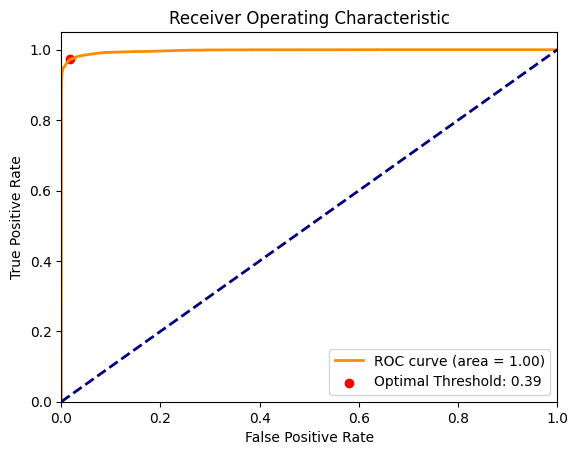

Optimal Threshold: 0.39


In [31]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming you have your binary classification model predictions and true labels
y_true = y_train#[0, 1, 1, 0, 1, 0, 0, 1, 0, 1]  # True labels
y_scores = Y_train_predicted#[0.2, 0.7, 0.8, 0.3, 0.6, 0.1, 0.4, 0.9, 0.5, 0.7]  # Model predictions (scores)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
optimal_threshold = thresholds[np.argmin(np.sqrt((1 - tpr) ** 2 + fpr ** 2))]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[np.argmin(np.sqrt((1 - tpr) ** 2 + fpr ** 2))], tpr[np.argmin(np.sqrt((1 - tpr) ** 2 + fpr ** 2))], color='red', marker='o', label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print(f'Optimal Threshold: {optimal_threshold:.2f}')

In [32]:
Y_predicted = Y_train_predicted.flatten()
Y_predicted

array([0.00342942, 0.04507355, 0.48686737, ..., 0.9830551 , 0.9832097 ,
       0.98291564], dtype=float32)

In [33]:
Y_predicted1 = np.where(Y_predicted >= 0.45, 1, 0)
Y_predicted1

array([0, 0, 1, ..., 1, 1, 1])

In [34]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_train, Y_predicted1)
cm

array([[57661,   969],
       [ 1678, 56952]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

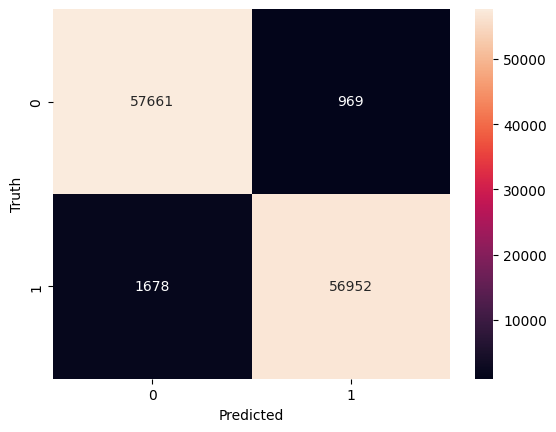

In [35]:
from matplotlib import pyplot as plt
import seaborn as sn

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [36]:
print(classification_report(y_train, Y_predicted1))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98     58630
           1       0.98      0.97      0.98     58630

    accuracy                           0.98    117260
   macro avg       0.98      0.98      0.98    117260
weighted avg       0.98      0.98      0.98    117260



# Testing Begins from here

In [37]:
Y_selected = test[selected_features]
Y_selected_test = scaler.fit_transform(Y_selected)
y_predicted = model.predict(Y_selected_test)

705/705 [==============================] - 9s 13ms/step


In [38]:
y_predicted = y_predicted.flatten()

In [39]:
y_predicted

array([0.9535019 , 0.95231485, 0.761979  , ..., 0.00479463, 0.00232635,
       0.9500629 ], dtype=float32)

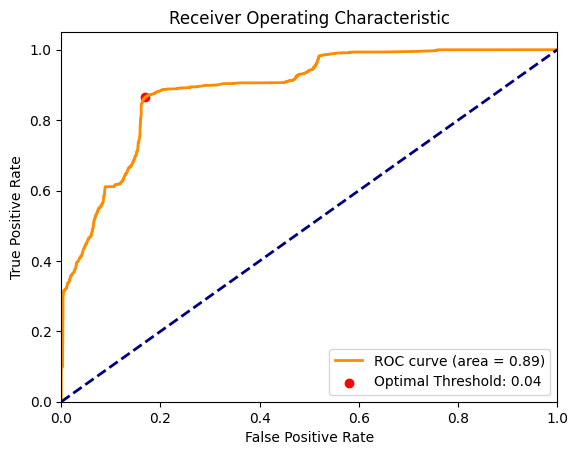

Optimal Threshold: 0.04


In [40]:
# Assuming you have your binary classification model predictions and true labels
y_true = y_test#[0, 1, 1, 0, 1, 0, 0, 1, 0, 1]  # True labels
y_scores = y_predicted#[0.2, 0.7, 0.8, 0.3, 0.6, 0.1, 0.4, 0.9, 0.5, 0.7]  # Model predictions (scores)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Find the optimal threshold
optimal_threshold = thresholds[np.argmin(np.sqrt((1 - tpr) ** 2 + fpr ** 2))]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[np.argmin(np.sqrt((1 - tpr) ** 2 + fpr ** 2))], tpr[np.argmin(np.sqrt((1 - tpr) ** 2 + fpr ** 2))], color='red', marker='o', label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

print(f'Optimal Threshold: {optimal_threshold:.2f}')

In [41]:
import numpy as np

y_predicted1 = np.where(y_predicted >= 0.01, 1, 0)
y_predicted1

array([1, 1, 1, ..., 0, 0, 1])

In [42]:
cm = confusion_matrix(y_test, y_predicted1)
cm

array([[ 7844,  1867],
       [ 1543, 11290]], dtype=int64)

Text(50.722222222222214, 0.5, 'Truth')

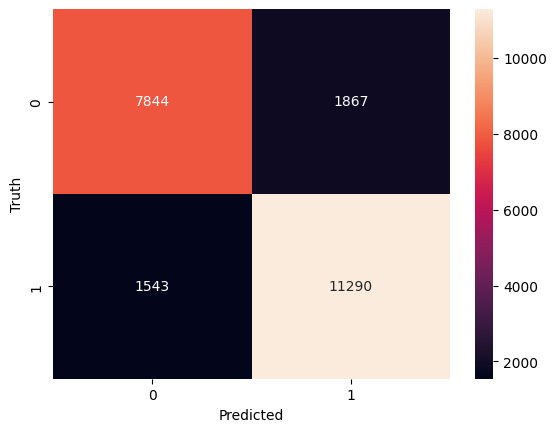

In [43]:
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [44]:
print(classification_report(y_test, y_predicted1))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82      9711
           1       0.86      0.88      0.87     12833

    accuracy                           0.85     22544
   macro avg       0.85      0.84      0.85     22544
weighted avg       0.85      0.85      0.85     22544

